In [ ]:
!pip install numpy==1.24.4 --force-reinstall


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is 

In [ ]:

import kagglehub
snehilsanyal_construction_site_safety_image_dataset_roboflow_path = kagglehub.dataset_download('snehilsanyal/construction-site-safety-image-dataset-roboflow')

print('Data source import complete.')


Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# About

- In this notebook I will train Yolo v8 model to detect PPE (Personal Protective Equipment), using [this existing dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow) from [Roboflow](https://universe.roboflow.com/)

___

[CSS (Construction Site Safety) Dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow):

- Labels in this dataset:
    - 0: Hardhat
    - 1: Mask
    - 2: NO-Hardhat
    - 3: NO-Mask
    - 4: NO-Safety Vest
    - 5: Person
    - 6: Safety Cone
    - 7: Safety Vest
    - 8: Machinery
    - 9: Vehicle


- More info:
    - Number of classes: 10
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`
      
___      

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

**<font color='orange'>If you like this notebook, don't forget to show your support with your upvote!</font>**

In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cad7823d-e728-44be-995e-166d61b28788)


# Installs/Imports

In [ ]:
%%time

! pip install ultralytics -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.5/983.5 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.1 MB/s eta 0:00:00
CPU times: user 643 ms, sys: 128 ms, total: 771 ms
Wall time: 1min 44s


In [ ]:
import ultralytics
print(ultralytics.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
8.3.115


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [ ]:
! wandb disabled

W&B disabled.


# CFG

- CFG class enables easy and organized experimentation
- Set `DEBUG = True` to make quick experiments

In [ ]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 100 # 100
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov8n' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/'
    OUTPUT_DIR = './'

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [ ]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [ ]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test
train: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train
val: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid



# Dataset

- Check some images
- Image utils

## Visualize one image

In [ ]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



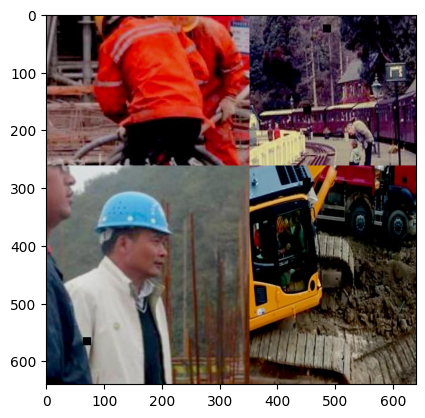

In [ ]:
example_image_path = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

## Visualize many images

In [ ]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

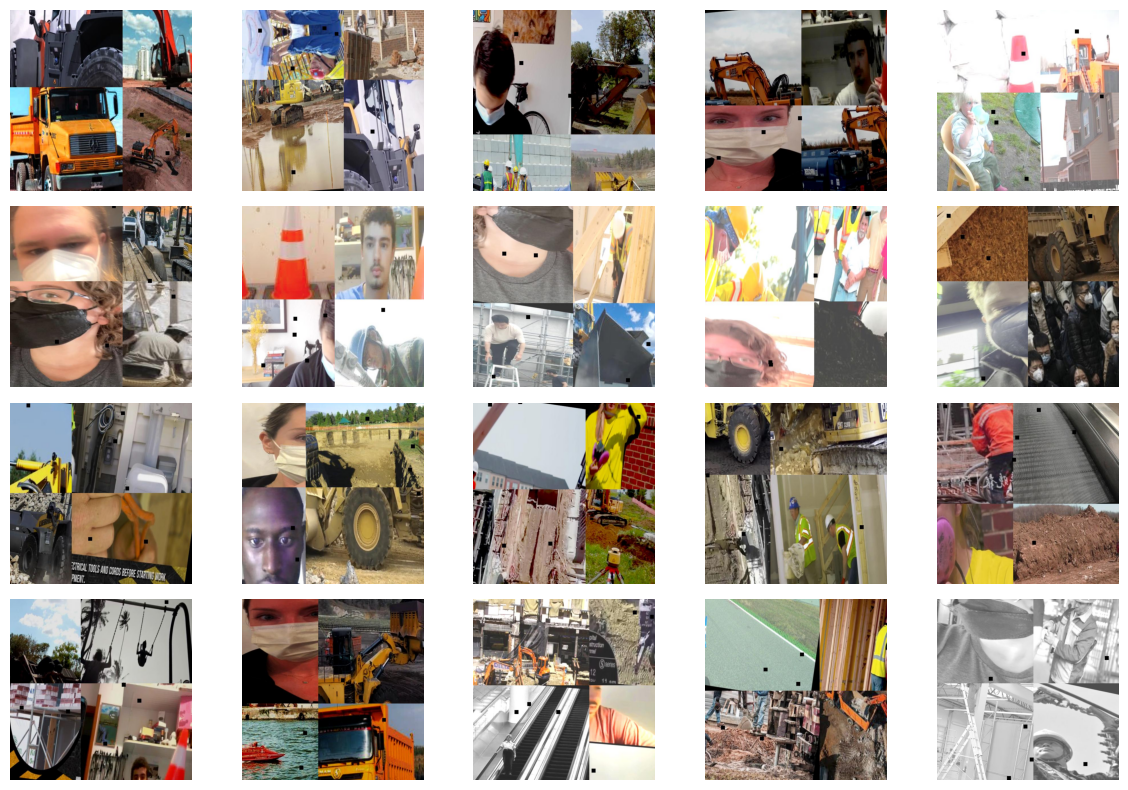

In [ ]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

## Image properties

In [ ]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [ ]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [ ]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 106 ms, sys: 95.5 ms, total: 202 ms
Wall time: 1.23 s


,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


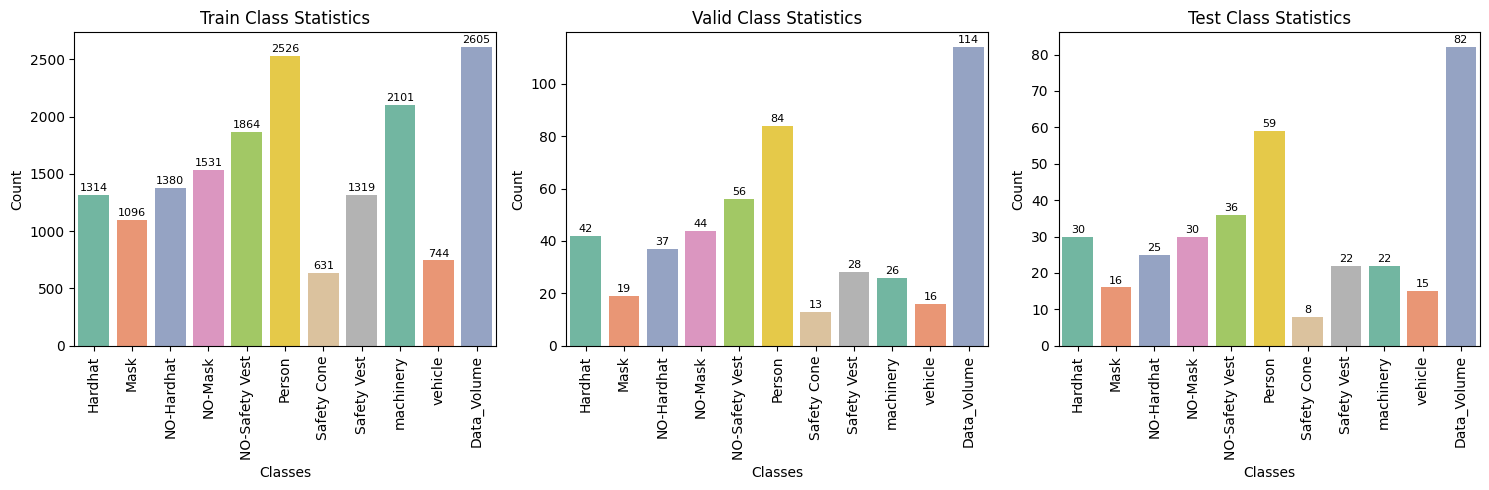

In [ ]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Image sizes

In [ ]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)


CPU times: user 252 ms, sys: 158 ms, total: 410 ms
Wall time: 1.5 s


# Base Model Inference

- Just checking the power of the pretrained model inference on the CSS dataset

In [ ]:
CFG.BASE_MODEL_WEIGHTS

'yolov8n.pt'

In [ ]:
import torch
model = YOLO(CFG.BASE_MODEL_WEIGHTS)
device = 0 if torch.cuda.is_available() else 'cpu'
results = model.predict(
    source=example_image_path,
    conf=0.20,
    device=device,
    imgsz=(img_properties['height'], img_properties['width']),
    save=True,
    save_txt=True,
    save_conf=True,
    exist_ok=True,
)


100%|██████████| 6.25M/6.25M [00:00<00:00, 261MB/s]



image 1/1 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 6 persons, 1 car, 1 bus, 1 truck, 1 tie, 11.9ms
Speed: 6.1ms preprocess, 11.9ms inference, 393.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


# Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [ ]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8n.pt
Epochs:  120
Batch:  16


In [ ]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [ ]:
%%time
project_path = "/content/drive/MyDrive/yolov8_runs"
### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = 0, # 0
    verbose = False,
)

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.115 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./data.yaml, epochs=120, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8n_ppe_css_120_epochs, exist_ok=True, pretrained=True, optimizer=SGD, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_

100%|██████████| 755k/755k [00:00<00:00, 119MB/s]

Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

Model summary: 129 layers, 3,012,798 parameters, 3,012,782 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 305MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
train: Fast image access ✅ (ping: 0.1±0.2 ms, read: 107.5±53.7 MB/s, size: 56.3 KB)


train: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:04<00:00, 549.57it/s]

train: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed
WARNING ⚠️ train: Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 120.4±27.0 MB/s, size: 53.1 KB)


val: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 430.26it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid is not writeable, cache not saved.


Plotting labels to runs/detect/yolov8n_ppe_css_120_epochs/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_ppe_css_120_epochs
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      3.01G      1.431      3.437      1.507        218        640: 100%|██████████| 163/163 [00:52<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        114        697      0.842     0.0501     0.0329     0.0164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      3.03G      1.292      2.938      1.397        186        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        114        697      0.612      0.103      0.143     0.0645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      3.04G      1.256      2.409      1.374        245        640: 100%|██████████| 163/163 [00:50<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        114        697      0.484      0.287      0.292       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      3.05G      1.242      2.067      1.364        259        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        114        697      0.574       0.39      0.403      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      3.06G      1.214      1.894       1.34        333        640: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        114        697      0.638      0.391      0.465       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      3.07G      1.193      1.783      1.334        252        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


                   all        114        697      0.607      0.464      0.504       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      3.08G      1.159      1.697      1.312        300        640: 100%|██████████| 163/163 [00:48<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


                   all        114        697      0.674      0.494      0.543      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      3.09G      1.159      1.654      1.312        265        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


                   all        114        697      0.672      0.505      0.562      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120      3.11G      1.135      1.602      1.301        212        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        114        697      0.712      0.523      0.585      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      3.12G      1.125      1.548      1.297        235        640: 100%|██████████| 163/163 [00:48<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


                   all        114        697      0.683      0.555      0.588      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      3.13G      1.117      1.512      1.279        313        640: 100%|██████████| 163/163 [00:49<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


                   all        114        697       0.75      0.561      0.623       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      3.14G      1.101      1.485      1.273        317        640: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


                   all        114        697      0.772      0.566      0.628       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      3.15G      1.101      1.466      1.273        227        640: 100%|██████████| 163/163 [00:50<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


                   all        114        697      0.724      0.585      0.635      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      3.16G      1.101      1.438      1.268        250        640: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

                   all        114        697      0.841      0.558      0.644      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      3.17G      1.076      1.417       1.26        297        640: 100%|██████████| 163/163 [00:47<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


                   all        114        697      0.764      0.598      0.654      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      3.18G      1.075      1.404      1.259        305        640: 100%|██████████| 163/163 [00:47<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        114        697      0.799      0.582      0.649      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120       3.2G      1.074      1.392      1.252        228        640: 100%|██████████| 163/163 [00:47<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


                   all        114        697      0.745      0.614      0.656      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      3.21G      1.061      1.367      1.252        267        640: 100%|██████████| 163/163 [00:48<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


                   all        114        697       0.77      0.618      0.666      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      3.22G      1.066      1.344      1.241        267        640: 100%|██████████| 163/163 [00:48<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


                   all        114        697      0.797        0.6      0.666       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      3.23G      1.056      1.333      1.239        300        640: 100%|██████████| 163/163 [00:49<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


                   all        114        697      0.828      0.589      0.667       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      3.24G       1.05      1.317      1.233        221        640: 100%|██████████| 163/163 [00:47<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


                   all        114        697      0.764      0.628       0.67      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      3.25G      1.042        1.3      1.235        272        640: 100%|██████████| 163/163 [00:49<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        697      0.797      0.618      0.681      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     23/120      3.26G      1.046      1.305      1.231        239        640: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        114        697      0.815      0.602      0.686      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      3.28G       1.04      1.272      1.217        319        640: 100%|██████████| 163/163 [00:49<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        114        697      0.806       0.62      0.676      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     25/120      3.29G       1.03      1.275      1.226        225        640: 100%|██████████| 163/163 [00:46<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        114        697      0.791      0.639      0.689      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120       3.3G      1.027      1.258      1.215        199        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


                   all        114        697      0.808      0.624      0.681      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      3.31G      1.023      1.245      1.214        309        640: 100%|██████████| 163/163 [00:46<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        114        697      0.848      0.624      0.705      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      3.32G      1.028      1.239       1.21        275        640: 100%|██████████| 163/163 [00:48<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


                   all        114        697      0.834      0.624       0.69      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      3.33G      1.017      1.224      1.214        250        640: 100%|██████████| 163/163 [00:46<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        114        697      0.847      0.624      0.693      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     30/120      3.35G      1.023      1.229      1.207        316        640: 100%|██████████| 163/163 [00:48<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


                   all        114        697       0.78      0.626      0.683      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      3.36G       1.01      1.217      1.207        241        640: 100%|██████████| 163/163 [00:46<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


                   all        114        697      0.812      0.629      0.699      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      3.37G      1.005      1.202      1.206        275        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


                   all        114        697      0.831      0.628      0.703      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      3.38G      1.003      1.196      1.202        333        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


                   all        114        697      0.837      0.619      0.702      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      3.39G      1.005      1.192      1.196        293        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


                   all        114        697      0.837      0.628      0.704       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120       3.4G     0.9862      1.174      1.195        339        640: 100%|██████████| 163/163 [00:46<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


                   all        114        697      0.852      0.622      0.701      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      3.41G     0.9935      1.174      1.199        316        640: 100%|██████████| 163/163 [00:49<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


                   all        114        697      0.811      0.646       0.71      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      3.42G      1.001      1.175      1.198        259        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        114        697      0.831      0.624      0.702      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     38/120      3.44G     0.9903      1.165      1.192        259        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


                   all        114        697      0.861      0.658      0.722      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      3.45G       0.98      1.152      1.189        426        640: 100%|██████████| 163/163 [00:46<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        114        697      0.796      0.651      0.708      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      3.46G     0.9809      1.139      1.186        309        640: 100%|██████████| 163/163 [00:47<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        114        697      0.826      0.637      0.704      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      3.47G     0.9808       1.15       1.19        318        640: 100%|██████████| 163/163 [00:46<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


                   all        114        697      0.793       0.65      0.706      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      3.48G     0.9793      1.129      1.185        279        640: 100%|██████████| 163/163 [00:45<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        114        697      0.864      0.639      0.719       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      3.49G     0.9764      1.133      1.183        408        640: 100%|██████████| 163/163 [00:46<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


                   all        114        697      0.854      0.659      0.716      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      3.51G     0.9716      1.126      1.181        211        640: 100%|██████████| 163/163 [00:45<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


                   all        114        697      0.807      0.661      0.712       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      3.52G     0.9726      1.118      1.179        329        640: 100%|██████████| 163/163 [00:47<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


                   all        114        697      0.794      0.669      0.717      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      3.53G     0.9606      1.112      1.176        337        640: 100%|██████████| 163/163 [00:46<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


                   all        114        697      0.852      0.638       0.71      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      3.54G     0.9583      1.112      1.174        236        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


                   all        114        697      0.843      0.636      0.717      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      3.55G     0.9665      1.105      1.171        263        640: 100%|██████████| 163/163 [00:45<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        114        697      0.838      0.657      0.724      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      3.56G     0.9718      1.098      1.176        349        640: 100%|██████████| 163/163 [00:46<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        114        697      0.831      0.643      0.716      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      3.57G     0.9528      1.093      1.175        239        640: 100%|██████████| 163/163 [00:45<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

                   all        114        697      0.833       0.64      0.717      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      3.58G     0.9585      1.093      1.173        273        640: 100%|██████████| 163/163 [00:46<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        114        697      0.833      0.636      0.717      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120       3.6G     0.9532      1.082      1.169        219        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        114        697      0.856      0.649      0.731       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      3.61G       0.95      1.085      1.168        246        640: 100%|██████████| 163/163 [00:46<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        114        697      0.843      0.648      0.726      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      3.62G     0.9571      1.081      1.169        222        640: 100%|██████████| 163/163 [00:47<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


                   all        114        697       0.86      0.648      0.728      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      3.63G     0.9505      1.075      1.165        267        640: 100%|██████████| 163/163 [00:46<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


                   all        114        697      0.846      0.653      0.723      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      3.64G     0.9529      1.072      1.167        198        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all        114        697      0.845      0.661      0.729      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      3.65G     0.9431      1.068      1.165        333        640: 100%|██████████| 163/163 [00:45<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


                   all        114        697      0.848      0.649      0.723      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      3.67G     0.9389      1.066      1.161        230        640: 100%|██████████| 163/163 [00:47<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        114        697      0.829      0.661      0.725      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      3.68G     0.9416      1.059      1.161        296        640: 100%|██████████| 163/163 [00:45<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

                   all        114        697      0.848      0.659      0.731      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      3.69G     0.9395      1.058      1.161        239        640: 100%|██████████| 163/163 [00:45<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        114        697      0.826       0.67      0.728      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120       3.7G     0.9437      1.055      1.161        371        640: 100%|██████████| 163/163 [00:47<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        114        697      0.864      0.663      0.731      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      3.71G     0.9306       1.05      1.154        290        640: 100%|██████████| 163/163 [00:45<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        114        697       0.87      0.658      0.732      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      3.72G     0.9321       1.05      1.154        314        640: 100%|██████████| 163/163 [00:46<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

                   all        114        697      0.859       0.65      0.726      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      3.73G      0.922      1.031      1.148        192        640: 100%|██████████| 163/163 [00:46<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all        114        697      0.859       0.65      0.731      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      3.75G     0.9323      1.036      1.156        346        640: 100%|██████████| 163/163 [00:46<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        114        697      0.858      0.644      0.736      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      3.76G     0.9329      1.041      1.156        231        640: 100%|██████████| 163/163 [00:47<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


                   all        114        697      0.825      0.665      0.731      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      3.77G     0.9226       1.03      1.148        262        640: 100%|██████████| 163/163 [00:47<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        114        697      0.837      0.662      0.727      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      3.78G     0.9172      1.028      1.148        408        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


                   all        114        697      0.867       0.66      0.735      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      3.79G     0.9178      1.017      1.148        365        640: 100%|██████████| 163/163 [00:46<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


                   all        114        697      0.857      0.646      0.725      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120       3.8G     0.9179      1.017      1.144        367        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        114        697      0.848      0.673      0.741      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     71/120      3.81G     0.9157      1.022      1.148        311        640: 100%|██████████| 163/163 [00:46<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


                   all        114        697      0.858      0.667      0.739      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      3.82G      0.914      1.008      1.137        244        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        114        697      0.858      0.652      0.733       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     73/120      3.84G     0.9195      1.017      1.148        241        640: 100%|██████████| 163/163 [00:47<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        114        697      0.839      0.649      0.731       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     74/120      3.85G     0.9121      1.012      1.144        266        640: 100%|██████████| 163/163 [00:48<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


                   all        114        697      0.844      0.661      0.735      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      3.86G     0.9181      1.001      1.142        315        640: 100%|██████████| 163/163 [00:46<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


                   all        114        697      0.848      0.645      0.735      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      3.87G     0.9156      1.006      1.141        247        640: 100%|██████████| 163/163 [00:48<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


                   all        114        697      0.833      0.652      0.731       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120      3.88G      0.912       1.01       1.14        182        640: 100%|██████████| 163/163 [00:45<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all        114        697      0.824      0.675      0.739      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      3.89G     0.9116     0.9944      1.139        284        640: 100%|██████████| 163/163 [00:45<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        114        697      0.876      0.642      0.731      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120       3.9G      0.902     0.9887      1.141        283        640: 100%|██████████| 163/163 [00:46<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


                   all        114        697      0.862      0.663      0.737      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      3.92G     0.9104     0.9862      1.136        261        640: 100%|██████████| 163/163 [00:45<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

                   all        114        697      0.845      0.666      0.738      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      3.93G     0.9051     0.9877      1.137        306        640: 100%|██████████| 163/163 [00:46<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        114        697      0.876      0.635      0.735      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     82/120      3.94G     0.9126     0.9949      1.135        273        640: 100%|██████████| 163/163 [00:46<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


                   all        114        697      0.884      0.655      0.746      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      3.95G     0.9046     0.9849      1.137        289        640: 100%|██████████| 163/163 [00:46<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        114        697      0.894      0.654      0.743      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      3.96G     0.9085     0.9876      1.137        375        640: 100%|██████████| 163/163 [00:46<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all        114        697      0.888      0.656       0.75      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      4.34G     0.9024      0.989      1.134        387        640: 100%|██████████| 163/163 [00:45<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        114        697      0.836      0.677       0.74      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      4.36G     0.8919     0.9807      1.134        247        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


                   all        114        697      0.849       0.65      0.735      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120      4.37G     0.8991     0.9787      1.134        326        640: 100%|██████████| 163/163 [00:45<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


                   all        114        697      0.866      0.656      0.742      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      4.38G     0.8988     0.9769      1.134        230        640: 100%|██████████| 163/163 [00:46<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        114        697      0.838      0.666      0.738      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      4.39G     0.8919     0.9778      1.131        223        640: 100%|██████████| 163/163 [00:46<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


                   all        114        697      0.818      0.678      0.738      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120       4.4G     0.8973     0.9747      1.131        375        640: 100%|██████████| 163/163 [00:47<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        114        697      0.852      0.661      0.739      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120      4.41G     0.8977     0.9806      1.136        223        640: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all        114        697      0.857      0.679       0.75      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     92/120      4.42G     0.8992     0.9743      1.133        277        640: 100%|██████████| 163/163 [00:47<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        114        697      0.838      0.677      0.747      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      4.44G     0.8858     0.9699      1.129        291        640: 100%|██████████| 163/163 [00:48<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        114        697      0.871      0.661      0.751      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     94/120      4.45G     0.8904     0.9715      1.131        253        640: 100%|██████████| 163/163 [00:47<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        114        697      0.864      0.665      0.746      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      4.46G     0.8846     0.9528      1.123        277        640: 100%|██████████| 163/163 [00:48<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


                   all        114        697      0.848      0.683      0.751      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      4.47G     0.8882     0.9625      1.129        298        640: 100%|██████████| 163/163 [00:48<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        114        697      0.853      0.679      0.747      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      4.48G     0.8946     0.9647      1.131        218        640: 100%|██████████| 163/163 [00:47<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all        114        697      0.865      0.658      0.745      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120      4.49G     0.8862     0.9541      1.126        299        640: 100%|██████████| 163/163 [00:45<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


                   all        114        697      0.868      0.663      0.744      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120       4.5G     0.8818     0.9508      1.122        343        640: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        114        697      0.854      0.663      0.746      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    100/120      4.52G      0.877     0.9536      1.123        298        640: 100%|██████████| 163/163 [00:46<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        114        697      0.821      0.685      0.748      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      4.53G     0.8757     0.9564      1.121        245        640: 100%|██████████| 163/163 [00:47<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        114        697      0.846      0.668      0.748      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    102/120      4.54G     0.8778     0.9487       1.12        303        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]


                   all        114        697      0.847      0.683      0.756      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      4.55G     0.8805     0.9513      1.122        255        640: 100%|██████████| 163/163 [00:48<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


                   all        114        697      0.872      0.664      0.749      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      4.56G     0.8764     0.9547      1.124        361        640: 100%|██████████| 163/163 [00:46<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]


                   all        114        697      0.826      0.683      0.752      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      4.57G     0.8768     0.9487      1.119        269        640: 100%|██████████| 163/163 [00:47<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        114        697      0.855       0.67      0.751      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      4.58G     0.8779     0.9487      1.119        311        640: 100%|██████████| 163/163 [00:48<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all        114        697      0.858      0.671      0.749      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      4.59G     0.8751     0.9465       1.12        261        640: 100%|██████████| 163/163 [00:47<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        114        697      0.869      0.671      0.753      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    108/120      4.61G     0.8691     0.9417      1.122        213        640: 100%|██████████| 163/163 [00:47<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        114        697       0.86       0.67      0.749       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      4.62G      0.875     0.9338      1.113        285        640: 100%|██████████| 163/163 [00:48<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        114        697      0.867      0.668      0.754      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      4.63G     0.8754     0.9513      1.123        229        640: 100%|██████████| 163/163 [00:47<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


                   all        114        697      0.872       0.66      0.752      0.451
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120      4.64G     0.9164     0.9929      1.144        141        640: 100%|██████████| 163/163 [00:45<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        114        697      0.826      0.664      0.728      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      4.65G     0.8936     0.9436      1.133        179        640: 100%|██████████| 163/163 [00:44<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


                   all        114        697      0.858       0.66      0.738      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      4.66G     0.8883     0.9353      1.131        160        640: 100%|██████████| 163/163 [00:44<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


                   all        114        697      0.837      0.681      0.741       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      4.67G     0.8903     0.9308      1.127        171        640: 100%|██████████| 163/163 [00:44<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


                   all        114        697      0.838       0.68       0.74      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      4.69G     0.8839     0.9241      1.124        167        640: 100%|██████████| 163/163 [00:45<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


                   all        114        697      0.849      0.678      0.747      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120       4.7G     0.8835     0.9194      1.125        173        640: 100%|██████████| 163/163 [00:44<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


                   all        114        697      0.846      0.676      0.745      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      4.71G     0.8812     0.9215      1.126        203        640: 100%|██████████| 163/163 [00:44<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


                   all        114        697      0.861      0.675      0.748      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      4.72G     0.8793     0.9209      1.122        172        640: 100%|██████████| 163/163 [00:44<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


                   all        114        697      0.855      0.679      0.748      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      4.73G      0.877     0.9138      1.122        204        640: 100%|██████████| 163/163 [00:45<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


                   all        114        697      0.869      0.678      0.749      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      4.74G     0.8707     0.9059      1.114        144        640: 100%|██████████| 163/163 [00:44<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all        114        697      0.863      0.678      0.747      0.446



120 epochs completed in 1.637 hours.
Optimizer stripped from runs/detect/yolov8n_ppe_css_120_epochs/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n_ppe_css_120_epochs/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n_ppe_css_120_epochs/weights/best.pt...
Ultralytics 8.3.115 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


                   all        114        697      0.872       0.66      0.751      0.451
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to runs/detect/yolov8n_ppe_css_120_epochs
CPU times: user 50min 11s, sys: 2min 33s, total: 52min 45s
Wall time: 1h 38min 45s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79bbfa021f50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

# Export

- [Export mode](https://docs.ultralytics.com/modes/export/) is used for exporting a YOLOv8 model to a format that can be used for deployment. In this mode, the model is converted to a format that can be used by other software applications or hardware devices. This mode is useful when deploying the model to production environments.

In [ ]:
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [ ]:

# Export to ONNX format
model.export(format="onnx", opset=12)


Ultralytics 8.3.115 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/yolov8n_ppe_css_120_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 246.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 351.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 195.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 286.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 351.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 15.6s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
WARNING ⚠️ requirements: Restart runtim

'runs/detect/yolov8n_ppe_css_120_epochs/weights/best.onnx'

In [ ]:


# ✅ Load your PyTorch checkpoint
model = YOLO("runs/detect/yolov8n_ppe_css_120_epochs/weights/best.pt")

# ✅ Export to TensorFlow Lite
model.export(
    format='tflite',      # or 'onnx', 'coreml', etc.
    int8=False,           # set True for quantization
    imgsz=(640, 640),
    dynamic=False,
    nms=True
)


Ultralytics 8.3.115 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/yolov8n_ppe_css_120_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (6.0 MB)
ERROR ❌ TensorFlow SavedModel: export failure 0.0s: module 'numpy' has no attribute 'dtypes'


AttributeError: module 'numpy' has no attribute 'dtypes'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!zip -r /content/drive/MyDrive/ppe_model_backup.zip /content/runs/detect/Yolov8newfiles


	zip warning: name not matched: /content/runs/detect/Yolov8newfiles

zip error: Nothing to do! (try: zip -r /content/drive/MyDrive/ppe_model_backup.zip . -i /content/runs/detect/Yolov8newfiles)


# Train results

In [ ]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov8n_ppe_css_120_epochs/P_curve.png',
 './runs/detect/yolov8n_ppe_css_120_epochs/F1_curve.png',
 './runs/detect/yolov8n_ppe_css_120_epochs/R_curve.png',
 './runs/detect/yolov8n_ppe_css_120_epochs/confusion_matrix.png',
 './runs/detect/yolov8n_ppe_css_120_epochs/PR_curve.png',
 './runs/detect/yolov8n_ppe_css_120_epochs/results.png',
 './runs/detect/yolov8n_ppe_css_120_epochs/confusion_matrix_normalized.png',
 './runs/detect/yolov8n_ppe_css_120_epochs/labels.jpg',
 './runs/detect/yolov8n_ppe_css_120_epochs/labels_correlogram.jpg']

./runs/detect/yolov8n_ppe_css_120_epochs/F1_curve.png


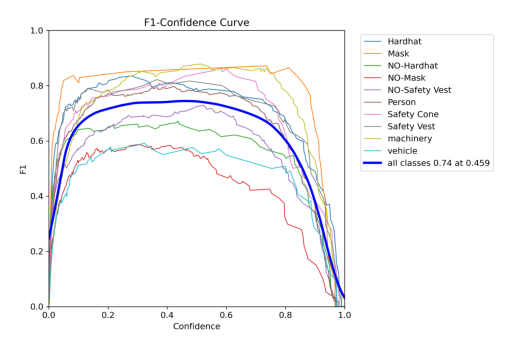



./runs/detect/yolov8n_ppe_css_120_epochs/PR_curve.png


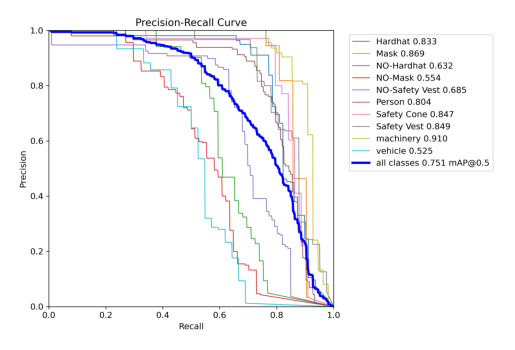



./runs/detect/yolov8n_ppe_css_120_epochs/P_curve.png


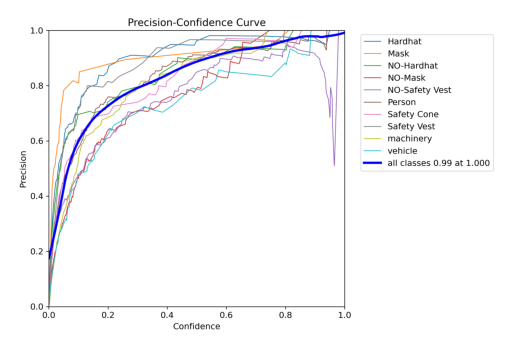



./runs/detect/yolov8n_ppe_css_120_epochs/R_curve.png


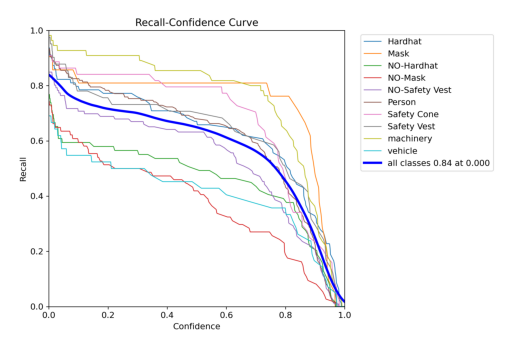



./runs/detect/yolov8n_ppe_css_120_epochs/confusion_matrix.png


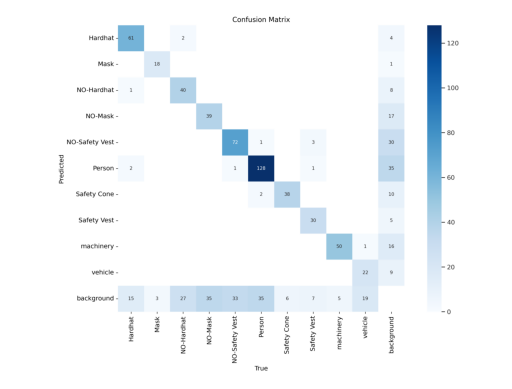



./runs/detect/yolov8n_ppe_css_120_epochs/confusion_matrix_normalized.png


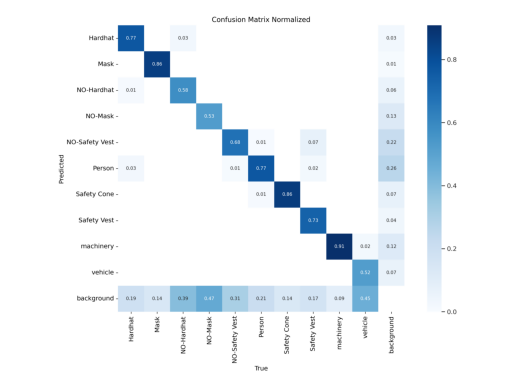



./runs/detect/yolov8n_ppe_css_120_epochs/labels.jpg


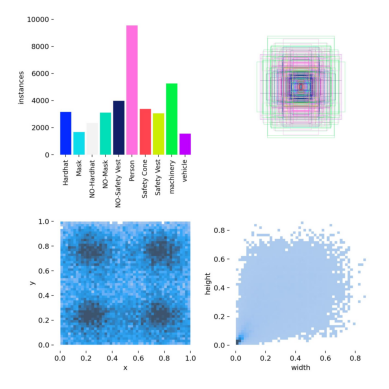



./runs/detect/yolov8n_ppe_css_120_epochs/labels_correlogram.jpg


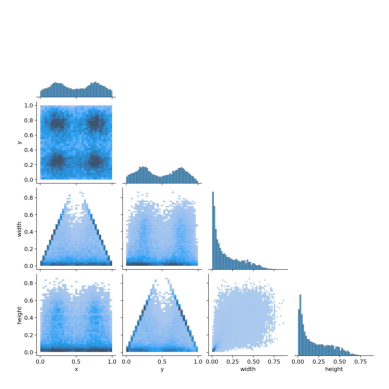



./runs/detect/yolov8n_ppe_css_120_epochs/results.png


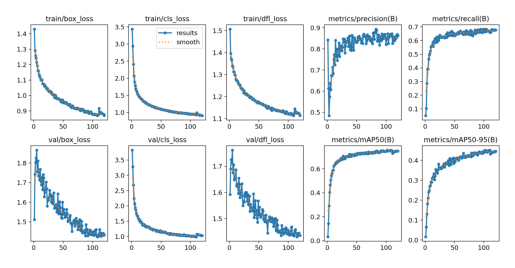

In [ ]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

# Loss

- The loss function in YOLO consists of three main components: box loss, class loss (cls loss), and objectness loss (dfl loss).
- The total loss in YOLO is a combination of these three components

___

**Box loss:**
- The box loss measures how accurately the predicted bounding box coordinates match the ground truth bounding box.
- Is typically computed using a regression loss, such as Mean Squared Error (MSE), between the predicted bounding box coordinates (center coordinates, width, and height) and the ground truth bounding box coordinates.

___

**Class loss (cls):**
- The class loss measures how well the predicted class probabilities match the true class labels.
- The class loss is usually computed using a categorical cross-entropy loss, which penalizes the difference between the predicted class probabilities and the true class labels.

___

**Objectness loss (dfl):**
- Distribution Focal Loss
- YOLO predicts an "objectness" score for each bounding box, indicating the presence of an object within the grid cell. This score helps filter out irrelevant bounding boxes.
- The objectness loss is calculated based on the difference between the predicted objectness score and the ground truth objectness label. It penalizes the model for false positives and false negatives in predicting the presence of an object.

In [ ]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,55.7807,1.43084,3.43654,1.50745,0.84196,0.05007,0.03290,0.01638,1.51205,3.82194,1.59201,0.067202,0.000331,0.000331
1,2,106.6510,1.29222,2.93836,1.39705,0.61230,0.10325,0.14274,0.06449,1.74138,3.27808,1.68960,0.034197,0.000659,0.000659
2,3,158.9600,1.25616,2.40939,1.37368,0.48403,0.28710,0.29242,0.12967,1.80362,2.68517,1.72566,0.001186,0.000981,0.000981
3,4,211.2180,1.24235,2.06745,1.36412,0.57380,0.39042,0.40273,0.18118,1.82452,2.23826,1.71355,0.000975,0.000975,0.000975
4,5,261.8340,1.21448,1.89427,1.33957,0.63805,0.39134,0.46543,0.20968,1.86564,2.06755,1.76178,0.000967,0.000967,0.000967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,116,5707.5700,0.88351,0.91936,1.12497,0.84580,0.67581,0.74489,0.44155,1.43405,1.04773,1.43909,0.000051,0.000051,0.000051
116,117,5754.1500,0.88124,0.92153,1.12611,0.86068,0.67496,0.74788,0.44376,1.44204,1.04004,1.44400,0.000043,0.000043,0.000043
117,118,5800.8100,0.87926,0.92088,1.12239,0.85523,0.67932,0.74774,0.44242,1.44163,1.03275,1.44443,0.000035,0.000035,0.000035
118,119,5848.3100,0.87705,0.91380,1.12189,0.86893,0.67828,0.74903,0.44566,1.43234,1.03087,1.43718,0.000027,0.000027,0.000027


In [ ]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.8691 , on epoch:  108 


Best Validation Box loss:  1.4242 , on epoch:  108 


Best Training Cls loss:  0.9059 , on epoch:  120 


Best Validation Cls loss:  0.99081 , on epoch:  108 


Best Training DFL loss:  1.11323 , on epoch:  109 


Best Validation DFL loss:  1.43076 , on epoch:  115 



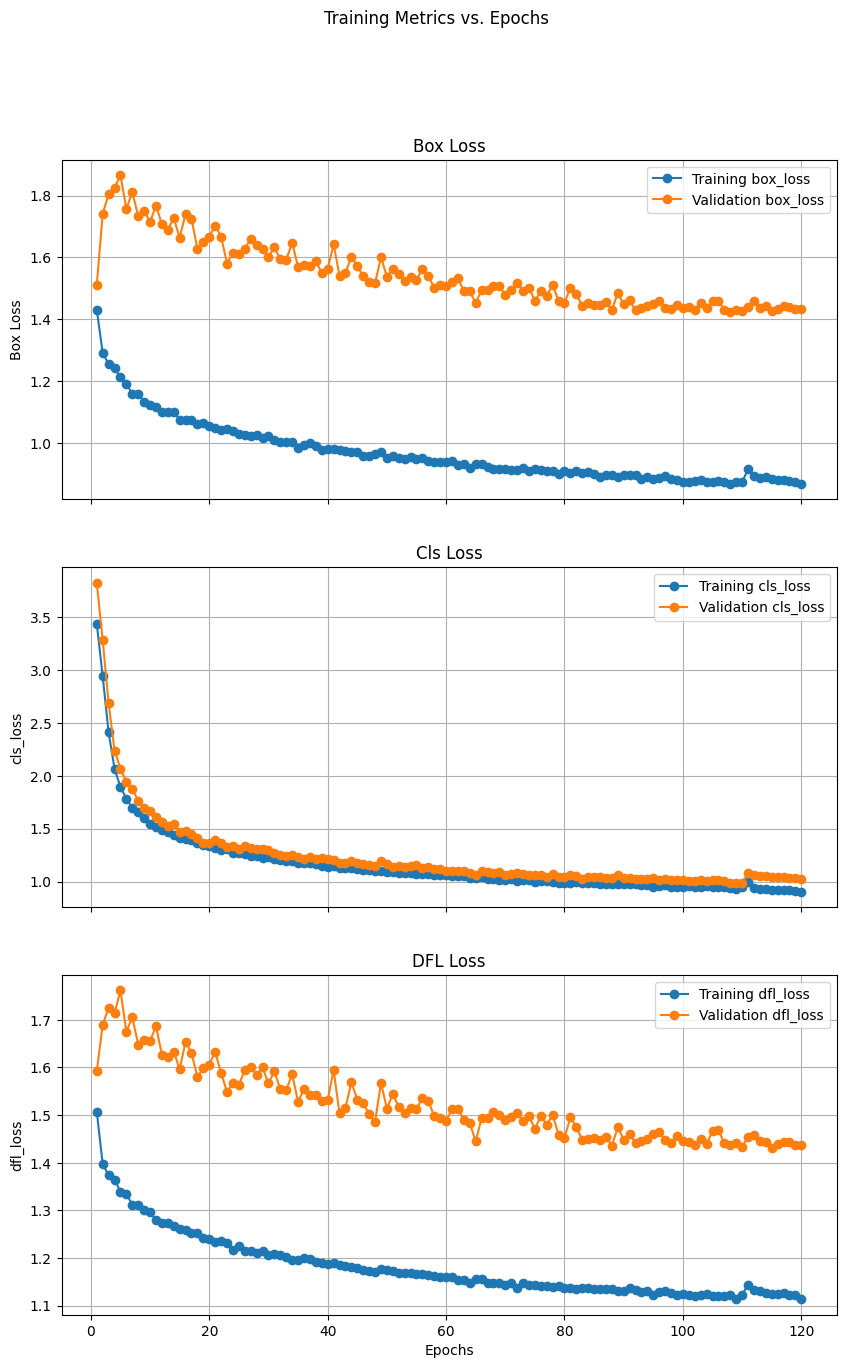

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

# Validation results

In [ ]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [ ]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov8n_ppe_css_120_epochs/val_batch2_labels.jpg


./runs/detect/yolov8n_ppe_css_120_epochs/val_batch2_pred.jpg


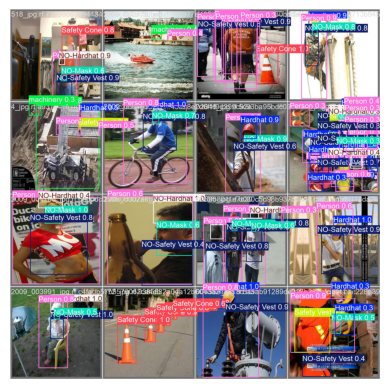

In [ ]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

# Conclusions

- So now the model is trained and we have customized Yolo to detect PPE.
- In my [next notebook](https://www.kaggle.com/hinepo/yolov8-inference-for-red-zone-application) I will use this model to make inference on a video, and combine the PPE detection with a Red Zone application.
- **<font color='orange'>Upvote if you liked it!</font>**

In [ ]:
from google.colab import files

uploaded = files.upload()  # Choose a .jpg or .jpeg image


Saving imga.jpg to imga.jpg


In [ ]:
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

# Load your trained model
model = YOLO("runs/detect/yolov8n_ppe_css_120_epochs/weights/best.onnx")

# Get the uploaded image path
image_path = list(uploaded.keys())[0]

# Run inference
results = model.predict(
    source=image_path,
    conf=0.2,
    save=True
)


Loading runs/detect/yolov8n_ppe_css_120_epochs/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

image 1/1 /content/imga.jpg: 640x640 1 Hardhat, 1 NO-Mask, 1 Person, 1 Safety Vest, 8.4ms
Speed: 5.3ms preprocess, 8.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


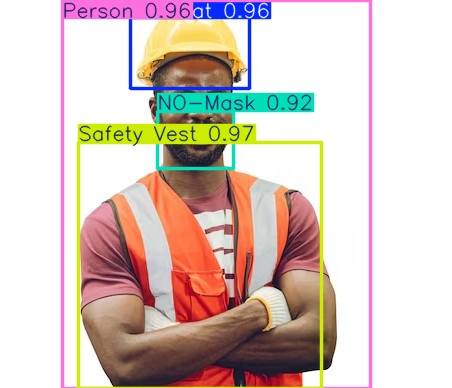

In [ ]:
import os
from PIL import Image
from IPython.display import display

# Get the correct save directory from the first result
save_dir = results[0].save_dir

# Find the predicted image inside the save_dir
predicted_images = [f for f in os.listdir(save_dir) if f.endswith(".jpg")]

# Display the first predicted image
display(Image.open(os.path.join(save_dir, predicted_images[0])))


In [ ]:
!pip install -q tflite-runtime


In [ ]:
from google.colab import files
uploaded_model = files.upload()  # Upload best_int8.tflite


In [ ]:
uploaded_img = files.upload()  # Upload a .jpg test image
image_path = list(uploaded_img.keys())[0]


In [ ]:
import tflite_runtime.interpreter as tflite
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image and resize it to 640x640
image = Image.open(image_path).convert("RGB").resize((640, 640))
input_data = np.expand_dims(np.array(image, dtype=np.uint8), axis=0)

# Load the TFLite model
interpreter = tflite.Interpreter(model_path="best_int8.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Fetch output
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Raw TFLite Output:\n", output_data)
